### <u>Read Me</u>:

The format of this notebook is as follows. The third cell, largest below and referred to as "the main cell," houses all of the functions used. The capabilities of each function are described in the following cells in the order that they are called. The comments in the main cell explain the line above them and assume the reader has already read the other cell (found elsewhere in the notebook) that explains the purpose of the function in which it is contained. Cells which explain the purspose of a function contain bolded names, these signify that the word is the name of an important variable (list, dictionary, etc.) or function.

# <u>Run The Cell Below Before Continuing</u>

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def add_one_hot(df, cat=None, manual=None, words=None, debug=None):
    """This function has two main functionalities. It takes in one mandatory
    input (df) and four optional inputs (cat, manual, words, debug). When
    manual is not specified, the function requires that cat be specified. It
    will then add a one hot matrix of the specified column to the dataframe
    provided as df. If manual is specified, then the function requires words
    to be specified. It then iterates through the list of words provided in
    words and addes columns of the them into the dataframe. It then iterates
    through the rows in the "summary" column of the dataframe and adds a 1 to
    the specific word column if the summary contains that specific word. The
    optional debug input will simply print when the function is running and
    when it has ran. The function will always return an edited dataframe."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING add_one_hot...')
        # notifies the user when the function is running
    if not manual:
        # when the manual variable is not specified...
        one_hot = pd.get_dummies(df[cat], prefix=cat)
        # creating a dataframe of dummy variables (1 or 0) while also...
        # ...setting a prefix for each column of the original container column
        # this prevents an error where the columns are attempting to be...
        # ...named the same name.
        df.drop(cat, axis=1, inplace=True)
        # drop the original column in the data
        df = df.join(one_hot)
        # join the edited original dataframe with the dummy variables
        if debug:
            # optional debug variable will print the line below
            print('\nRAN add_one_hot')
            # notifies the user when the function has ran
        return df
    if manual:
        # when the mainual variable is specified...
        for word in words:
            # iterating through the words specified in words
            df[word] = None
            # creates a column of NaN values in the specified dataframe
        for index, summary in enumerate(df['summary']):
            # iterating through the summaries in the original dataframe
            for word in summary.split():
                # splits the summary into words
                if word.lower().strip().replace('.', '') in words:
                    # deletes periods for purposes of standardization then...
                    # ...checks if the word is in the specified word list
                    df.iloc[index,
                            list(df.columns).index(
                                word.lower().strip().replace('.', ''))] = 1
                    # finds the exact row and column index of the word being...
                    # ...checked if it is in the summary and changes its...
                    # ...values to 1
        df.fillna(0, inplace=True)
        # now that all words that are in each specific summary are set...
        # ...to 1, the rest of the None values are set to 0 to signify...
        # their not being in the summary
        df.drop('summary', inplace=True, axis=1)
        # drops the existing summary column from the original dataframe
        if debug:
            # optional debug variable will print the line below
            print('\nRAN add_one_hot')
            # notifies the user when the function has ran
        return df


def adusted_R2(model, X, y, debug=None):
    """This function takes in a model (class object), X (dataframe), y
    (series), and an optional debug input (can be any input). It adjustes
    for the number of predictor variables (columns in X) to evaluate the
    accuracy of the model specified. The optional debug input will simply print
    when the function is running and when it has ran. The function returns the
    adjusted R^2 value as an int."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING adusted_R2...')
        # notifies the user when the function is running
    if debug:
        # optional debug variable will print the line below
        print('\nRAN adusted_R2')
        # notifies the user when the fuction has run
    adjusted = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
    # the function above penalizes the R^2 with a greater length of X
    return adjusted


def clean_data(data, debug=None):
    """This function only takes in two input, with one being optional. The
    first input is a dataframe and the second an optional debug input (which
    will print when the function is running and when it has finished running,
    any value can be inputted into the debug variable). The function will then
    drop all NaN data and fix the date and summary columns. The function then
    returns an edited dataframe."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING clean_data...')
        # notifies the user when the function is running
    data.dropna(how="any", inplace=True)
    # drops any row with a missing values
    data.columns = data.columns.str.strip()
    # strips all the column names of whitespace
    data.columns = data.columns.str.lower()
    # lowers the case of all the columns
    data.drop(columns=['flight #', 'registration', 'cn/ln'],
              inplace=True)
    # drops unnecessary columns that would not affect the target variable
    data['percent_dead'] = (data['fatalities']+data['ground'])/data['aboard']
    # creates the percent_dead column by summing the air and ground...
    # fatalities then dividing by total aboard
    data['date'] = data['date'] + ' ' + data['time']
    # makes the date column a single column containing the date and time
    data['date'] = data['date'].astype('datetime64[ns]')
    # uses the datetime to make the date column a datetime object
    data['hour'] = data.date.dt.hour
    # creates another column only for the hour of the crash
    data['month'] = data.date.dt.month
    # creates another column only for the month of the crash
    cols = ['fatalities', 'fatalities passangers', 'fatalities crew',
            'time', 'ground', 'date']
    # specifies all the columns to be dropped after being edited above
    data.drop(columns=cols, inplace=True)
    # drops the specified columns
    data['summary'] = data['summary'].str.lower()
    # lowers the case of all the enteries in the entires summary columns
    i = list(data.columns).index('summary')
    # specifies the column index of summary as "i"
    for index, summary in enumerate(data['summary']):
        # iterates through each summary in the summary column
        data.iloc[index,
                  i] = summary.replace('.', '')
        # replaces any periods in the specific summary with nothing (deletes)
        data.iloc[index,
                  i] = summary.replace(',', '')
        # replaces any commas in the specific summary with nothing (deletes)
        data.iloc[index,
                  i] = summary.replace('failed', 'failure')
        # replaces "failed" in the specific summary with "faliure" for...
        # purposes of standardizing the data
    data.reset_index(drop=True, inplace=True)
    # resets the index of the dataframe to be correct
    if debug:
        # optional debug variable will print the line below
        print('\nRAN clean_data')
        # notifies the user when the function has run
    return data


def add_one_hots(data, debug=None):
    """This function takes in two variables, the first being a madatory
    dataframe (df) and the second being an option debug variable (which will
    notify the user when the function is running and has run). THe function
    will then use the add_one_hot function to append one hot matricies to
    the given dataframe (with the columns being immutable by the user).
    The function then returns an edited dataframe."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING add_one_hots...')
        # notifies the user when the function is running
    data.reset_index(inplace=True, drop=True)
    # resets the index of the given dataframe to be correct
    one_hot_columns = ['ac type', 'location',
                       'operator', 'route']
    # specifies the columns to be converted to one hot matricies
    for column in one_hot_columns:
        # iterating through the specified columns
        data = add_one_hot(cat=column, df=data, debug=debug)
        # uses the function add_one_hit to add one hot columns for the...
        # ...specified columns
    if debug:
        # optional debug variable will print the line below
        print('\nRAN add_one_hots')
        # notifies the user when the fucntion has run
    return data


def psuedo_fix_summaries(data, good_words, debug=None):
    """This function is purely for demostration purposes. It takes in three
    inputs, being a dataframe, a list of words, and an optional debug input
    (which will notify the user when the function is running and has run).
    The function will then change the summary column to the first instance
    of any word it shares with the specified word list. This function is
    used as an example for why one should make the summary column a one hot
    matrix of important words and not simply do the above. The function then
    returns an edited dataframe."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING fix_summaries...')
        # notifies the user when the function is running
    for good_word in good_words:
        # iterates through each word in the given list of words
        for good_tup in [(index,
                          good_word)
                         for index, summary in enumerate(data['summary'])
                         if good_word in summary.lower().strip()]:
            # iterates through a list containing tuples of the following...
            # ...format: (row index, first instance of shared word with list)
            data.iloc[int(good_tup[0]),
                      list(data.columns).index('summary')] = good_word
            # sets the row index summary to the first instance of shared word
    if debug:
        # optional debug variable will print the line below
        print('\nRAN fix_summaries(data, good_words)')
        # notifies the user when the function has run
    return data


def find_frequent_words(debug=None):
    """This function only takes in an optional debug input (which notifies
    the user when the function is running and has run). The function exists
    for simplicity's sake. The function always returns a specified list of
    words to be used by the add_one_hot function."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING find_frequent_words...')
        # notifies the user when the function is running
    words = ['crashed', 'approach', 'runway',
             'failure', 'engine', 'landing', 'airport',
             'control', 'fire', 'weather', 'accident',
             'struck', 'takeoff', 'captain',
             'descent', 'killed', 'wing', 'fuel',
             'error', 'emergency', 'mountain',
             'route', 'system', 'pilots', 'broke',
             'instrument', 'severe', 'stall']
    # the above list of words was determined by analyzing the most...
    # ...frequent words in all the summaries in the summary column
    # these words were chosen based on their ability to represent...
    # ...different possible events in a crash
    if debug:
        # optional debug variable will print the line below
        print('\nRAN find_frequent_words')
        # notifies the user when the function has run
    return words


def get_relevant_features(value, df, specifics, pr=None, debug=None):
    """This function takes in three required inputs and three optional inputs.
    The purpose of the function is to present, in an organized manner, all the
    correlations to a certain specified variable in a dataframe. The required
    inputs are value, df, and specifics. value is the tagret variable to which
    all other variables' correlation will be measured. df is the dateframe for
    which one would like to find the correlations. specifics is the cutoff for
    the definition of "relevant correlation." pr is an optional variable that
    will create a heatmap if it is specified to anything (works well only with
    smaller dataframes). Debug is an optional variable that will notify the
    user when the function is running and has run."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING get_relevant_features...')
        # notifies the user when the function is running
    if pr:
        # optional pr variable will show the specific heatmap below
        plt.figure(figsize=(12, 10))
        # sets the size of the heatmap
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        # creates the heatmap
        plt.show()
        # displays the heatmap
    cor = df.corr()
    # stores all the correlations of every variable with every other variable
    cor_target = abs(cor[value])
    # specifies that the target value (specifics) can either be...
    # ...positive or negative (positive or negative correlation)
    relevant_features = cor_target[cor_target >= specifics]
    # trims the cors to only have correlations that are greater than or...
    # ...equal to the target value
    if debug:
        # optional debug variable will print the line below
        print('\nRAN get_relevant_features')
        # notifies the user when the function has run
    return relevant_features


def apply_polynomial_features(df, mindegree, maxdegree, show=None, debug=None):
    """This function is mainly for demontrational perposes. It takes in
    three required variables: df (dataframe), mindegree (int), and maxdegree
    (int). It will then strip the non-catagorical data from the dataframe
    provided (specific to the airplane crahses csv). Then, it iterates
    through the non-catagorical data and performs and regression after
    applying polynomial features to the data (dependent on the mindegree
    and maxdegree variables). The optional variables that this function
    takes in are show and debug. Both can be specified to any value to be
    activated. Show will display a graph of Train Error vs. Test Error (the
    absolute minimum intersection being the optiomal polynomial features
    degree: "low bias vs. low variance"). This function returns the
    non-catagorical varibales fitted with polynomial features of degree 1
    as a tuple (essentially doing nothing, but done for the demonstration
    purposes)."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING apply_polynomial_features...')
        # notifies the user when the function is running
    y = df['percent_dead']
    # isolates the predictor variable as a series
    stop_col = "ac type_\tBoeing 737-8KN (WL)"
    # this is the column for which the catagorical variables stop
    non_cats = df.drop(df.iloc[:, list(df.columns).index(stop_col):], axis=1)
    # specifies all the non-catagorical X variables as dataframe non_cats
    non_cats.drop('percent_dead', inplace=True, axis=1)
    # drops the predictor variable from the x values so that it is...
    # ...not adjusted
    cats = df.drop(df.iloc[:, :list(df.columns).index(stop_col)], axis=1)
    # specifies all of the catagorical variables as the dataframe cats
    # this dataframe will be used later when the data is rejoined
    X_train, X_test, y_train, y_test = train_test_split(
        non_cats, y, test_size=0.3)
    # splits the non-catagorical variables into a training and test set
    train_error = []
    # empty list will be used to house all the various training error...
    # ...produced in the loop below
    test_error = []
    # empty list will be used to house all the various testing error...
    # ...produced in the loop below
    for deg in range(mindegree, maxdegree):
        # loops through the range of degrees specified by the user
        if show:
            # optional show variable will print the line below
            print(f"on degree {deg}...")
            # notifies the user which on which degree the loop is
        model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
        # creates a pipeline object (model) with polynomial and linear features
        model.fit(X_train, y_train)
        # fits the model to the training data
        train_error.append(mean_squared_error(y_train, model.predict(X_train)))
        # obtains the mean squared error of the training set regression...
        # ...and appends it to the train_error list
        test_error.append(mean_squared_error(y_test, model.predict(X_test)))
        # obtains the mean squared error of the testing set regression...
        # ...and appends it to the test_error list
    if show:
        # optional show variable will display the following
        print(f"Train Error: {train_error}\nTest Error: {test_error}")
        # prints both training and testing error lists
        plt.plot(np.arange(mindegree, maxdegree),
                 train_error, color='green', label='train')
        # plots the training error on a scatter plot (connecting points)
        plt.plot(np.arange(mindegree, maxdegree),
                 test_error, color='red', label='test')
        # plots the testing error on the scatter plot (connecting points)
        plt.ylabel('mean squared error')
        plt.xlabel('degree')
        plt.legend(loc='upper left')
        # three lines above simply label the scatter plot created above
    if debug:
        # optional debug variable will print the line below
        print('\nRAN apply_polynomial_features')
        # notifies the user when the function has run
    poly = PolynomialFeatures(1)
    # creates polynomial features of degree 1
    poly.fit(non_cats)
    # applies the poly. feat. of degree 1 to non-catagorical variables
    # this was done rather symbolically, as applying poly. feat. of...
    # ...deg. 1 does not really do anything
    return poly.transform(non_cats), cats, y


def scale_data(df_poly, cats, y, debug=None):
    """This funciton uses 3 required variables and 1 optional input. The
    three required variables are produced by the function
    apply_polynomial_features (df_poly, cats, and y). df_poly is the
    transformed non-catagorical variables dataframe, cats is a dataframe
    conataining all the catagorical X values, and y is a series containing
    the predictor variable. The optional input is debug, which will notify
    the user when the function is running and has run. The function uses
    StandardScaler to return the scaled catagorical variables joined with
    the non-scaled catagorical variable and y series."""
    if debug:
        # optional debug variable will print line below
        print('\n\tRUNNING scale_data...')
        # notifies the user when the function is running
    scaler = StandardScaler()
    # screats standard scaler object
    scaler.fit(df_poly)
    # applies the scaler to the transformed non-catagorical data
    X_scaled = scaler.transform(df_poly)
    # creates a dataframe of scaled non-catagorical data
    X = cats.join(pd.DataFrame(X_scaled))
    # joins the scaled non-catagorical data with the catagorical data
    X['percent_dead'] = y
    # creates a percent_dead column in X that is the y series specified
    if debug:
        # optional debug variable will print the line below
        print('\nRAN scale_data')
        # notifies the user when the function has run
    return X


def create_model(X, y, mod, debug=None):
    """This function takes in the transformed X dataframe and
     non-transformed y series and creates a regression model based on the
     specified mod string. mod can be either 'linear' or 'ridgecv' (which
     will create a linear and ridgecv regression models respectively). The
     function also takes in an optional debug variable which will notify
     the user when the function is running and has run. The function
     returns a tuple containin the model, X_test set, and y_test set (to be
     used for calculating the R^2)."""
    if debug:
        # optional debug variable will print the line below
        print('\n\tRUNNING create_model...')
        # notifies the user when the functing is running
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # creates the training and testing sets
    if mod.lower().strip() == 'linear':
        # if the user has specified a linear regression
        model = LinearRegression()
        # creates linear model object
        model.fit(X_train, y_train)
        # fits the data using the linear object with respect to y
        if debug:
            # optional debug variable will print the line below
            print('\nRAN create_model')
            # notifies the user when the function has ran
    if mod.lower().strip() == 'ridgecv':
        # if the user has specified a ridgecv regression...
        model = RidgeCV(cv=10, alphas=[0.001, 0.01, 0.005, 0.01, 0.05,
                                       0.09, 0.1, 0.5, 0.9, 1])
        # creates the ridgecv object
        # more aphas were added in hopes of enhancing the regression
        model.fit(X_train, y_train)
        # fits the data using the ridgecv object with respect to y
    if debug:
        # optional debug variable will print the line below
        print('\nRAN create model')
        # notifies the user when the function has ran
    return model, X_test, y_test


def reset_place(p):
    """This function is only for the cleanliness of this Notebook. This
    function is never to be used by the user (hence no comments). The
    function only takes in one value (p) and returns the proper data
    or object to be used—this allows each cell in the notebook to be ran,
    given that this main cell has been run, without having to reset the
    dataframe in some way."""
    if p == 1:
        return pd.read_csv(
            'Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
    elif p == 2:
        return clean_data(reset_place(1))
    elif p == 3:
        return add_one_hots(reset_place(2))
    elif p == 4:
        s = 'summary'
        return reset_place(3).iloc[3,
                                   list(reset_place(3).columns).index(s)]
    elif p == 5:
        return add_one_hot(df=reset_place(3), manual=True,
                           words=find_frequent_words())
    elif p == 5.1:
        data = reset_place(5)
        col = "ac type_\tBoeing 737-8KN (WL)"
        non_cats = data.drop(data.iloc[:,
                                       list(data.columns).index(col):], axis=1)
        non_cats.drop('percent_dead', inplace=True, axis=1)
        y = data['percent_dead']
        return non_cats, y
    elif p == 5.2:
        df_poly, cats, y = apply_polynomial_features(reset_place(5), 0, 1)
        return scale_data(df_poly, cats, y)
    elif p == 6:
        data = reset_place(5.2)
        return data.iloc[:,
                         [list(data.columns).index(feature)
                          for feature in list(dict(
                              get_relevant_features(
                                  'percent_dead', data, 0.1)))]]
    elif p == 7:
        return reset_place(6).sample(frac=1).reset_index(drop=True)
    elif p == 8:
        data = reset_place(7)
        return data.drop('percent_dead', axis=1), data['percent_dead']


def get_base_dictionary(X, debug=None):
    """This function returns a nested dictionary with all the relevent X
    variables as keys with their values set to 0. This function takes in
    the given dataframe, X, as a required input and an optional debug
    variable (which will notify the user when the function is running
    and has ran). This function is only used in conjunction with the
    predict_dead function to allow the user to input variables based on asked
    questions."""
    if debug:
        # optional debug variable will print the line below
        print("\n\tRUNNING get_base_dictionary...")
        # notifies the user when the fucntion is running
    d = {}
    # initializes the dictonary to be returned as empty
    for label in ['ac', 'location', 'operator', 'route', 'crash']:
        # iterating through the first set of values to be in the nested dict.
        # this allows each set of important variables to be catagorized...
        # ...with a parent catagory
        d[label] = {}
        # initializes all the values of the just specified keys...
        # ...as empty dictionaries
    for index, c in enumerate(X.columns):
        # iterates through each column in the provided dataframe X
        if index < 5:
            # there are 4 important aircraft type columns
            # this if statement assigns the proper column value to...
            # ...the proper nested value
            d['ac'][c] = 0
            # sets all nested dictonary values to 0 in ac...
            # ...parent catagory
        elif 5 <= index <= 7:
            # there are 3 important location columns
            # this if statement assigns the proper column value to the...
            # ...proper nested value
            d['location'][c] = 0
            # sets all nested dictonary values to 0 in location...
            # ...parent catagory
        elif 7 < index <= 11:
            # there are 4 important operator columns
            # this if statement assigns the proper column value to the...
            # ...proper nested value
            d['operator'][c] = 0
            # sets all nested dictonary values to 0 in operator...
            # ...parent catagory
        elif 11 < index <= 15:
            # there are 4 important route columns
            # this if statement assigns the proper column value to the...
            # ...proper nested value
            d['route'][c] = 0
            # sets all nested dictonary values to 0 in route...
            # ...parent catagory
        elif index == 16:
            # there is 1 important crash column
            # this if statement assigns the proper column value to the...
            # ...proper nested value
            d['crash'][c] = 0
            # sets the nested dictonary value to 0 in crash...
            # ...parent catagory
    if debug:
        # optional debug variable will print the line below
        print("\n\tRAN get_base_dictonary")
        # notifies the user when the function has ran
    return d


def predict_dead(d, model, debug=None):
    """This function is responsible for predicting the percent dead in the
    event of a crash. This function takes in the dictonary provided from the
    function get_base_dictonary and asks the user questions regarding their
    hypothetical crash. Based on their answers to the questions, the function
    then modifies the base dictonary to match their responses. After
    modification, the user's answers are then stripped from the dictionary
    and inputted into model.predict and the corresponding value is returned."""
    if debug:
        # optional debug variable will print the line below
        print("\n\tRUNNING predict_dead...")
        # notifies the user when the function is running
    message = 'The following questions will'
    message += ' only accept "y" for yes or "n" for no.'
    message += '\nAny questions that are answered with'
    message += ' anything but a "y" will be regarded as a no.'
    print(message)
    # creates intructions for the user
    for key1, value1 in d.items():
        # iterates throught the dictionary items
        for key2, value2 in value1.items():
            # iterating throught the nested dictonary items
            if key1 == 'ac':
                # if the key is in ac, ask this question
                message1 = 'Would your aircraft be a'
                message1 += f' {key2.split("ac type_")[-1]}? '
                answer = input(message1)
            if key1 == 'location':
                # if the key is in location, ask this question
                message2 = 'Would your crash take place in'
                message2 += f' {key2.split("location_")[-1]}? '
                answer = input(message2)
            if key1 == 'operator':
                # if the key is in operator, ask this question
                message3 = 'Would your airline be'
                message3 += f' {key2.split("operator_")[-1]}? '
                answer = input(message3)
            if key1 == 'route':
                # if the key is in route, ask this question
                message4 = 'Would your route be'
                message4 += f' {key2.split("route_")[-1]}? '
                answer = input(message4)
            if key1 == 'crash':
                # if the key is in crash, ask this question
                answer = input(f'Would something with the {key2} go wrong? ')
            if answer == 'y':
                # if the user inputted yes, the value in the ...
                # ...nested dictonary will be set to 1
                d[key1][key2] = 1
                break
    var = []
    # empty list for all of the values to be stored
    for value in d.values():
        # iterates through the edited dictonary
        for value2 in value.values():
            # iterates through the edited nested dictonary
            var += [value2]
            # adds the value to the values list
    prediction = np.array(var).reshape(1, -1)
    # reshapes the list so that it can be inputted into model.predict
    if debug:
        # optional debug variable will print the line below
        print('\n\tRAN predict_dead')
        # notifies the user when the function has run
    return round(model.predict(prediction)[0], 2)


def test_suff(model, X_test, y_test, target, data, X):
    """This function is only used for the main function and it not used by
    the user. It takes in a model, two test dataframes (X and y), a value
    for an R^2 calculation, an entire dataframe (X and y) combined, and an
    X values dataframe. It then checks if the R^2 of the test data matches
    the target. If it does, it informs the user of what model was used. If
    not, it runs the main function again."""
    if model.score(X_test, y_test) < target:
        # if the R^2 values is not sufficient...
        print('\n\nmodel not sufficient')
        print(f"R^2 = {round(model.score(X_test, y_test), 2)}\n\n")
        # if it is not sufficient, print the R^2 value and inform the user
        return main(pass_=target, d=data)
        # returns the main function again
    else:
        # if the test R^2 value is sufficient...
        prediction = predict_dead(get_base_dictionary(X), model)
        R_2 = model.score(X_test, y_test)
        ad_R_2 = adusted_R2(model, X_test, y_test)
        mean_2_error = round(
            mean_squared_error(y_test, model.predict(X_test)), 2)
        # get all the above information and display it to the user
        print(f"""\n\n{round(prediction, 4)*100}% would die.
R^2: {R_2}
Adjusted R^2: {ad_R_2}
Mean Squared Error: {mean_2_error}""")


def mod(data):
    """This function performs a ridgecv regression only for the main function.
    It is not used by the user. The function returns a tuple of a model,
    X test dataframe, y test dataframe, and X values dataframe"""
    data = data.sample(frac=1).reset_index(drop=True)
    # shuffles the data
    X = data.drop('percent_dead', axis=1)
    # cretes X values dataframe
    y = data['percent_dead']
    # creates target value dataframe
    model, X_test, y_test = create_model(X, y, mod='ridgecv', debug=True)
    # uses create_model to get the model to be returned
    return model, X_test, y_test, X


def main(pass_=None, d=None):
    """This function has two main functionalities. shis is a sthing sd this"""
    """This is the main function. The pass_ and d variables are set by
    other functions and are never set by the user. Nothing is returned when
    this funtion is called."""
    if not pass_:
        # if the function is not being called again
        text = '''To what R^2 value would you like your model to be accurate?
For example, you could enter 0.7, 0.8, 0.85, etc: '''
        target = float(input(text))
        # sets the target R^2 values for the model
        if target > 1:
            T = 'That number is greater than 1.'
            T += 'Only enter a number between 0 and 1.'
            print(T)
            return main()
        elif target <= 0:
            T = "That number is less than or equal to 0"
            T += "Only enter a number between 0 and 1."
            print(T)
            return main()
        # if statements above correct the users input for the R^2 value
        data = pd.read_csv(
            'Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
        # reads in the dataframe
        data = clean_data(data, debug=True)
        # cleans the data
        data = add_one_hot(
            df=data, manual=True, words=find_frequent_words(), debug=True)
        # adds one hot matricies
        df_poly, cats, y = apply_polynomial_features(
            reset_place(5), 0, 1, debug=True)
        # applies polynomial features
        data = scale_data(df_poly, cats, y, debug=True)
        # scales the data
        data = data.iloc[:, [
            list(data.columns).index(feature) for feature in list(dict(
                get_relevant_features(
                    'percent_dead', data, 0.1, debug=True)))]]
        # reduces the dataframe to only relevant features
        model, X_test, y_test, X = mod(data)
        # creates the model
        test_suff(model, X_test, y_test, target, data, X)
        # checks if the model has a sufficient R^2 value for the user's target

    else:
        # if the function is being called again...
        target = pass_
        # target is what was previously specified
        data = d
        # data is the same dataframe
        model, X_test, y_test, X = mod(data)
        # creates a different model
        test_suff(model, X_test, y_test, target, data, X)
        # tests the R^2 value again


if __name__ == "__main__":
    pass
    # set to pass so that it does not run when the user...
    # ...first runs this cell

UsageError: Cell magic `%%pycodestyle` not found.


## Cleaning the Data
First, let's read in the Airplane csv file. We'll be using the information in this dataset to predict the likely %dead in the event of a plane crash.

In [5]:
data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
data.head()

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,09/07/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,07/12/1912,06:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


As we can see, we have <i> many </i> catagorical values that we'll want to convert to one hot matrices. But let's clean the data first. We'll do this by performing the following in order:
1. Drop any trivial information that would not imply causation (flight #, registration, and cn/ln—which is the serial number of the airplane).


2. Drop any missing values to simplify the regression model.


3. Clean the dataset's columns by stripping them of whitespace and lowering their case.


4. While still cleaning the data, we'll want to start adding columns. We only have the total amount of fatalities of passangers/crew/people on ground. We want to have the percent of onboard fatalities, so we'll add a column of the ground and onboard fatalities divided by the amount onboard then drop the passangers/crew/ground columns (this allows the column to be greater than one, meaning the crash killed some on the ground).


5. Convert the date and time columns to a single datetime column then drop the original date and time columns (we'll only save the hour and month).


6. Clean the summary columns. We'll be working with the summaries later to extract important words, so we'll want to make sure we standardize them (if possible). To do this, we'll get rid of the periods and commas in the summaries, then, because "failed" and "faliure" essentially imply the same thing in the summary, we'll convert failed to faliure so we mark them as the same (will be useful later).

That's it for cleaning! See the <b>clean_data</b>, which does all of the above in one line (line 2), function for more details. Run the cell below before continuing.

In [475]:
try:
    data = clean_data(data)
except KeyError:
    data = clean_data(reset_place(1))
data.head()

,location,operator,route,ac type,aboard,aboard passangers,aboard crew,summary,percent_dead,hour,month
0,"Oceanside, California",Maddux Airlines,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,16.0,14.0,2.0,"while en route to los angeles, the pilot, flyi...",1.000000,18,1
1,"Bazaar, Kansas",Trans Continental and Western Air,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,8.0,6.0,2.0,"shortly after taking off from kansas city, one...",1.000000,10,3
2,"Amazonia, Missouri",Rapid Air Transport,Kansas City - Saint Joseph - Omaha,Stinson SM-6000B,5.0,4.0,1.0,the plane crashed about 11 miles from st. jose...,1.000000,22,8
3,"Atlanta, Missouri",Trans Continental and Western Air,Los Angeles - Albuquerque - Kanasas City - Wa...,Douglas DC-2-112,14.0,12.0,2.0,the plane crashed while en route from albuquer...,0.357143,3,5
4,"Near Gilmer, Texas",Delta Air Lines,Dallas - Atlanta,Stinson Model A,4.0,3.0,1.0,crashed 3 miles south of gilmer. the outboard ...,1.000000,23,8


## Adding One Hot Matricies
Now that our data is cleaned, we can begin converting the catagorical information to one hot matricies. 


We know the catagorical columns for each crash are "ac type" (aircraft type), "location," "operator," and "route." So we'll want to create a matrix for each of these columns. Because this action is repetative, we can create an <b>add_one_hots</b> function that does the above quickly. 


This function takes in the previously described columns and runs another function, <b>add_one_hot</b>. They are similarly named but perform two different tasks for simplicity's sake: <b>add_one_hots</b> is specifically for fixing the catagorical information, but <b>add_one_hot</b> will add a one hot matrix for any specified column. We'll deal with the second-half of the <b>add_one_hot</b> function when we cover fixing the summary column, but let's focus on <b>add_one_hots</b> for now.


The <b>add_one_hots</b> function does the following:
1. Specifies the previously mentioned columns to be turned into one hot matricies.


2. Performs a loop for each mentioned column for <b>add_one_hot</b>.



On 2, the <b>add_one_hot</b> does the following:
1. Because the "manual" input is specified (only meaning it does not equal None), it creates a one hot matrix for each of the inputted, drops the original column, then joins the new data to the fixed dataset.


See the <b>add_one_hot</b> function in the main cell to see the specifics, but do not worry about confusion regarding the <b>add_one_hot</b>, as we'll talk more about it next.

That's it for fixing the catagorical information, run the cell below to do all the above in one line (line 2).

In [7]:
try:
    data = add_one_hots(data)
except KeyError:
    data = add_one_hots(reset_place(2))
data.head()

,aboard,aboard passangers,aboard crew,summary,percent_dead,hour,month,ac type_ Boeing 737-8KN (WL),ac type_ Antonov An-24 V,ac type_ Boeing 737-8F2,...,route_Yevlakh - Nuha,route_Yinchuan - Beijing,route_Yushno - Khabarovk,route_Yuzhno-Sakhalinsk - Khabarovsk,route_Zurich - Geneva,route_Zurich - Geneva - Athens - Bombay - Beijing,route_Zurich - Rabat,route_Zurich - Tel Aviv,route_Zurich-Genève-Funchal,route_Zürich - Dresden
0,16.0,14.0,2.0,"while en route to los angeles, the pilot, flyi...",1.000000,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.0,6.0,2.0,"shortly after taking off from kansas city, one...",1.000000,10,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,4.0,1.0,the plane crashed about 11 miles from st. jose...,1.000000,22,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.0,12.0,2.0,the plane crashed while en route from albuquer...,0.357143,3,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,3.0,1.0,crashed 3 miles south of gilmer. the outboard ...,1.000000,23,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Fixing the Summary Column
There are some inherant problems that are presented when analyzing the summary column. First, the column cannont simply be turned into a one hot matrix, as doing so would ensure no summary information would be shared with any other crash.

Therefore, we have to pick out the most common words from the summary column and create one hot matricies only for those words.


To do this, let's first see what our 10 most common words are:

In [8]:
data = reset_place(3)
# reseting the dataframe to our previous place
word_freq = {}
# creating a dictionary to be used to count each instance of each word
for summary in data['summary']:
    # iterating through each summary in the column
    for word in summary.split():
        # iterating through each word in the summary
        # .split() is needed, otherwise the loop would iterate through each character
        word_freq[word.lower().strip().replace('.','')] = word_freq.get(word, 0) + 1
        # if the word is in the dictionary, add one to its key
        # if not, initialize the new word key with 1
tups = [(freq, word) for word, freq in word_freq.items()]
# creates a list of tuples where the first item in the tuple is...
# ...the occurrences of the word and the second item is the word
tups.sort(reverse = True)
# sorts the tuples so the most frequent words appear first
for tup in tups[:10]:
    # only show the first 10 frequent words for simplicity
    print(tup)

(8374, 'the')
(2548, 'of')
(2315, 'and')
(2102, 'a')
(1414, 'in')
(1184, 'to')
(739, 'into')
(675, 'an')
(635, 'at')
(630, 'from')


As we can see from the tuples above, we need to eliminate all the trivial words like "the" and "a." These words signify nothing about the crash itself (and we are only looking for words that could describe what occured in the crash, essentially a single-word summary of the summary). 


Instead of greating a giant list of bad words, let's create a list of words we believe to be indicative of the type of crash. After examining all of the words in the list of tuples, the following list of <b>good_words</b> was created:

In [9]:
good_words = ['crashed',
              'approach',
              'runway',
              'failure',
              'engine',
              'landing',
              'airport',
              'control',
              'fire',
              'weather',
              'accident',
              'struck',
              'takeoff',
              'captain',
              'descent',
              'wing',
              'fuel',
              'error',
              'emergency',
              'mountain',
              'route',
              'system',
              'pilots',
              'broke',
              'instrument',
              'severe',
              'stall']
print(good_words)

['crashed', 'approach', 'runway', 'failure', 'engine', 'landing', 'airport', 'control', 'fire', 'weather', 'accident', 'struck', 'takeoff', 'captain', 'descent', 'wing', 'fuel', 'error', 'emergency', 'mountain', 'route', 'system', 'pilots', 'broke', 'instrument', 'severe', 'stall']


To avoid a lengthy list appearing in the middle of our code which runs all the functions in order, the <b>find_frequent_words</b> function was created—which only returns the above list.

In [10]:
good_words = find_frequent_words()
print(good_words)

['crashed', 'approach', 'runway', 'failure', 'engine', 'landing', 'airport', 'control', 'fire', 'weather', 'accident', 'struck', 'takeoff', 'captain', 'descent', 'killed', 'wing', 'fuel', 'error', 'emergency', 'mountain', 'route', 'system', 'pilots', 'broke', 'instrument', 'severe', 'stall']


Now let's use the generated <b>good_words</b> list to create one hot matricies of each important word contained in the column.


We can't just make the summary entry equal to the word found in that summary and then create a matrix because we would then be eliminating the possibility of a crash containing multiple good words. For example, let's examine the following summary:

In [11]:
data = reset_place(3)
example_summary = data.iloc[3, list(data.columns).index('summary')]
print(example_summary)

the plane crashed while en route from albuquerque to kansas city. after encountering fog and poor visibility, the plane was diverted to kirksville where witnesses reported the low flying aircraft made contact with the ground and crashed. whether the plane struck the ground while the pilot was attempting to make an emergency landing or because the available fuel supply had been exhausted, or for other reasons, could not be determined. new mexico senator bronson m. cutting, 46, killed. improper clearance of the airplane from albuquerque by the company's ground personnel when the plane's two-way radio was not functioning properly.


Using the <b>good_words</b> list, let's see what good words are in this summary:

In [12]:
try:
    print([word for word in example_summary.split() if word in good_words])
except NameError:
    print([word for word in reset_place(4).split() if word in find_frequent_words()])

['crashed', 'route', 'struck', 'emergency', 'landing', 'fuel']


6 good words! So what would happen if we were to simply convert the summaery column to the good word found inside it? It would conver the summary column for each crash to only <i>first</i> instance of a word in good words. Let's  use the <b>psuedo_fix_summaries</b> function to see what the previous summary would be turned into:

In [13]:
data = reset_place(3)
good_words = find_frequent_words()
bad_data = psuedo_fix_summaries(data, good_words)
print(bad_data.iloc[3, list(data.columns).index('summary')])

crashed


All of the other 5 words would not be counted. Therefore, we want to create a more complex function. 


The complex function would first need to add all the possible good words as new columns. Then, the function would need to iterate through each summary and set all the applicable good word columns to 1 if it is contained in the summary (or 0 if not). The optional "manual" input in <b>add_one_hot</b> does exactly this (named as such because we are manually creating one hot matricies). 


Run the cell below to call the  and read the comments in the main cell to read the specifics of the function.

In [14]:
data = reset_place(3)
good_words = find_frequent_words()
data = add_one_hot(df = data, manual = True, words = good_words)
data.head()

,aboard,aboard passangers,aboard crew,percent_dead,hour,month,ac type_ Boeing 737-8KN (WL),ac type_ Antonov An-24 V,ac type_ Boeing 737-8F2,ac type_ATR 42-300,...,error,emergency,mountain,route,system,pilots,broke,instrument,severe,stall
0,16.0,14.0,2.0,1.000000,18,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,8.0,6.0,2.0,1.000000,10,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,4.0,1.0,1.000000,22,8,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,14.0,12.0,2.0,0.357143,3,5,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,4.0,3.0,1.0,1.000000,23,8,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Polynomial Features
Before we continue to our regression, let's see if any of our data need to have polynomial features applied to it. Currently, we only have aboard, aboard passangers, aboard crew, hour, and month to work with in polynomial features (non-binary data). So let's specify our non-catigorical variables with <b>non_cats</b> and our predictor variable with <b>y</b> (we'll also want to save to catagorical data for later with <b>cats</b>.

In [48]:
try:
    non_cats = data.drop(data.iloc[:, list(data.columns).index("ac type_\tBoeing 737-8KN (WL)"):], axis = 1)
    non_cats.drop('percent_dead', inplace = True, axis = 1)
    y = data['percent_dead']
    cats = data.drop(data.iloc[:, :list(data.columns).index("ac type_\tBoeing 737-8KN (WL)")], axis = 1)
except KeyError:
    data = reset_place(5)
    non_cats = data.drop(data.iloc[:, list(data.columns).index("ac type_\tBoeing 737-8KN (WL)"):], axis = 1)
    non_cats.drop('percent_dead', inplace = True, axis = 1)
    y = data['percent_dead']
    cats = data.drop(data.iloc[:, :list(data.columns).index("ac type_\tBoeing 737-8KN (WL)")], axis = 1)
non_cats.head()

,aboard,aboard passangers,aboard crew,hour,month
0,16.0,14.0,2.0,18,1
1,8.0,6.0,2.0,10,3
2,5.0,4.0,1.0,22,8
3,14.0,12.0,2.0,3,5
4,4.0,3.0,1.0,23,8


Now let's make a test_train_split with the non-catagorical data.

In [49]:
try:
    X_train, X_test, y_train, y_test = train_test_split(non_cats, y, test_size=0.3)
except NameError:
    non_cats = reset_place(5.1)[0]
    X_train, X_test, y_train, y_test = train_test_split(non_cats, y, test_size=0.3)

Now, in order to find the best polynomial degree for our data, we can iterate through each degree we want and graph the test error vs. the train error (variance vs. bias). (don't worry about the function when the except is called, it simply does all of the code in try in one line).

on degree 1...
on degree 2...
on degree 3...
on degree 4...
on degree 5...
on degree 6...
on degree 7...
on degree 8...
on degree 9...
on degree 10...
on degree 11...
on degree 12...
on degree 13...
on degree 14...
on degree 15...
on degree 16...
on degree 17...
on degree 18...
on degree 19...


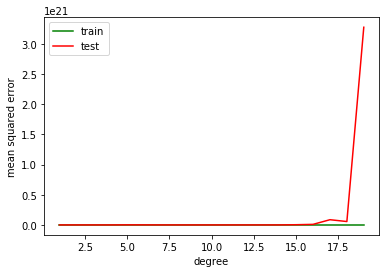

In [53]:
try:
    X_train, X_test, y_train, y_test = train_test_split(non_cats, y, test_size=0.3)
    train_error = []
    test_error = []
    for deg in range(1,20):
        print(f"on degree {deg}...")
        model = make_pipeline(PolynomialFeatures(deg),LinearRegression())
        model.fit(X_train,y_train)
        train_error.append(mean_squared_error(y_train,model.predict(X_train)))
        test_error.append(mean_squared_error(y_test,model.predict(X_test)))
    plt.plot(np.arange(1,20), train_error, color='green', label='train')
    plt.plot(np.arange(1,20), test_error, color='red', label='test')
    plt.ylabel('mean squared error')
    plt.xlabel('degree')
    plt.legend(loc='upper left')
except NameError:
    apply_polynomial_features(reset_place(5), 1, 20, show = True)

Our polynomials seems to have minimums from degrees 1 to 16, so let's zoom in on degrees 1 through 5 to see what's happening.

on degree 0...
on degree 1...
on degree 2...
on degree 3...
on degree 4...
on degree 5...


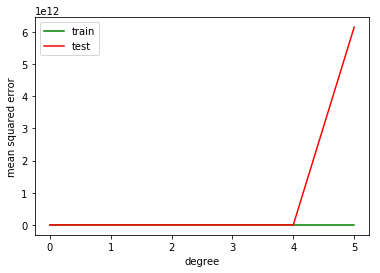

In [480]:
try:
    X_train, X_test, y_train, y_test = train_test_split(non_cats, y, test_size=0.3)
    train_error = []
    test_error = []
    for deg in range(0,6):
        print(f"on degree {deg}...")
        model = make_pipeline(PolynomialFeatures(deg),LinearRegression())
        model.fit(X_train,y_train)
        train_error.append(mean_squared_error(y_train,model.predict(X_train)))
        test_error.append(mean_squared_error(y_test,model.predict(X_test)))
    plt.plot(np.arange(0,6), train_error, color='green', label='train')
    plt.plot(np.arange(0,6), test_error, color='red', label='test')
    plt.ylabel('mean squared error')
    plt.xlabel('degree')
    plt.legend(loc='upper left')
except NameError:
    apply_polynomial_features(reset_place(5), 1, 6, show = True)

It seems that the lowest and simplest intersection of the mean squared error and degree is 1, so we need not apply polynomial features (apply polynomial features with degree 1). But we should still scale our non catagorical data:

In [82]:
df_poly, cats, y = apply_polynomial_features(reset_place(5), 0, 1)
scaler = StandardScaler()
scaler.fit(df_poly)
X_scaled = scaler.transform(df_poly)
X = cats.join(pd.DataFrame(X_scaled))
X.drop(0, axis = 1, inplace = True)
X['percent_dead'] = y
X.head()

,ac type_ Boeing 737-8KN (WL),ac type_ Antonov An-24 V,ac type_ Boeing 737-8F2,ac type_ATR 42-300,ac type_ATR 42-320,ac type_ATR 72-201,ac type_ATR 72-212,ac type_ATR 72-500,ac type_ATR 72-600,ac type_ATR-42-300,...,broke,instrument,severe,stall,1,2,3,4,5,percent_dead
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.685800,-0.653815,-0.964573,0.794312,-1.599344,1.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.801212,-0.774244,-0.964573,-0.477828,-1.039392,1.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.844491,-0.804352,-1.198219,1.430383,0.360489,1.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.714653,-0.683922,-0.964573,-1.590950,-0.479439,0.357143
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,-0.858918,-0.819405,-1.198219,1.589400,0.360489,1.000000


Or we could do all of the above in two lines using the <b>scale_dat</b> and <b>apply_polynomial_features</b> functions:

In [85]:
df_poly, cats, y = apply_polynomial_features(reset_place(5), 0, 1)
data = scale_data(df_poly, cats, y, debug = None)
data.head()

,ac type_ Boeing 737-8KN (WL),ac type_ Antonov An-24 V,ac type_ Boeing 737-8F2,ac type_ATR 42-300,ac type_ATR 42-320,ac type_ATR 72-201,ac type_ATR 72-212,ac type_ATR 72-500,ac type_ATR 72-600,ac type_ATR-42-300,...,broke,instrument,severe,stall,1,2,3,4,5,percent_dead
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.685800,-0.653815,-0.964573,0.794312,-1.599344,1.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.801212,-0.774244,-0.964573,-0.477828,-1.039392,1.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.844491,-0.804352,-1.198219,1.430383,0.360489,1.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.714653,-0.683922,-0.964573,-1.590950,-0.479439,0.357143
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,-0.858918,-0.819405,-1.198219,1.589400,0.360489,1.000000


## Getting Relevant Features
Out dataset is starting to get pretty lengthy, so let's see which columns we actually need.


Let's first see how each column is conncected to our predictior variable, percent_dead. We'll do this by running data.corr() with respect to our predictor variable:

In [88]:
data = reset_place(5.2)
correlations = data.corr()['percent_dead'].sort_values(ascending = False)
print(correlations)

percent_dead                                                        1.000000
route_Boston - Los Angeles                                          0.899966
ac type_Boeing B-767-222                                            0.745160
location_New York City, New York                                    0.551929
ac type_Boeing 767-223ER                                            0.527067
ac type_McDonnell Douglas DC-8F-55                                  0.217198
operator_AECA Cargo                                                 0.217198
route_Quito - Guayaquil                                             0.217198
ac type_Boeing B-747-258F                                           0.173285
route_Amsterdam - Tel Aviv                                          0.173285
operator_My Cargo Airlines (ACT Airlines)                           0.155720
route_Hong Kong - Bishkek - Istanbul                                0.155720
ac type_Boeing 747-412F                                             0.155720

Let's plot the correlation values to examine the distrabution:

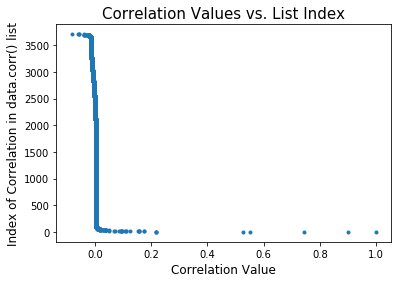

In [89]:
try:
    plt.plot(correlations, [i for i in range(len(correlations))], '.')
except NameError:
    plt.plot(reset_place(5.2).corr()['percent_dead'].sort_values(ascending = False),
             [i for i in range(len(correlations))], '.')
plt.xlabel('Correlation Value', size = 12)
plt.ylabel('Index of Correlation in data.corr() list', size = 12)
plt.title('Correlation Values vs. List Index', size = 15);

As we can see, there is a large amount of variables that we have added which are not greatly correlated to the percent_dead variable. Therefore, we can use this information to reduce our data to only the relevant features.

We chose not to use a histogram because less information is visable on the large scale (we would instead need to change our range between approximentally -0.01 and 0.01):

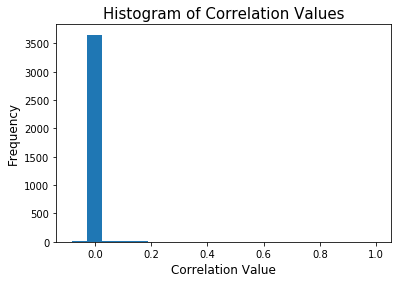

In [90]:
try:
    plt.hist(correlations, bins = 20)
except NameError:
    plt.hist(reset_place(5.2).corr()['percent_dead'].sort_values(ascending = False), bins = 20)
plt.xlabel('Correlation Value', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('Histogram of Correlation Values', size = 15);

To reduce the data to only the relevant features, we'll use data.corr() to search for correlation values greater that 0.1 (choses because of the plot above). Then we will return all the columns which have an absolute value of correlation greater than or equal to 0.1. We'll use these columns to reduce our dataframe to include <i>only</i> these columns. 


The get_relevant_features function does this in one line (line 2):

In [91]:
try:
    relevant_features = get_relevant_features('percent_dead',data,0.1)
except NameError:
    relevant_features = get_relevant_features('percent_dead', reset_place(5.2), 0.1)
print(relevant_features.sort_values(ascending = False))

percent_dead                                 1.000000
route_Boston - Los Angeles                   0.899966
ac type_Boeing B-767-222                     0.745160
location_New York City, New York             0.551929
ac type_Boeing 767-223ER                     0.527067
ac type_McDonnell Douglas DC-8F-55           0.217198
operator_AECA Cargo                          0.217198
route_Quito - Guayaquil                      0.217198
route_Amsterdam - Tel Aviv                   0.173285
ac type_Boeing B-747-258F                    0.173285
operator_My Cargo Airlines (ACT Airlines)    0.155720
route_Hong Kong - Bishkek - Istanbul         0.155720
ac type_Boeing 747-412F                      0.155720
location_Quito, Ecuador                      0.153576
operator_El Al                               0.124015
operator_United Air Lines                    0.110716
control                                      0.108645
location_Bishkek, Kyrgyzstan                 0.108552
Name: percent_dead, dtype: f

As we can see, we shrunk our dataset by more than 3000 input variables—meaning a lot of our above work was lost. But the last correlation, control, was part of the summary column originally—meaning all was not for nothing!


Now we can use the above relevant_features to reduce our dataframe to only include these features:

In [92]:
data = reset_place(5.2)
# ensure that the dataset always starts in the same state
indicies = []
# this list will contian all the indicies of the relevant features...
# ...inside of the dataframe columns
for feature in list(dict(get_relevant_features('percent_dead', data, 0.1))):
    # the np.array must be converted to a dictionary to obtain only the keys...
    # ...(labels). Then, the dictionary must be converted to a list to...
    # ...only obtain the keys.
    indicies.append(list(data.columns).index(feature))
    # this list of columns is then used to supply the index of the...
    # ...column in the original dataset
data = data.iloc[:,indicies]
# reduces the dataset to the identified important indicies
data.head()

,percent_dead,ac type_Boeing 747-412F,ac type_Boeing 767-223ER,ac type_Boeing B-747-258F,ac type_Boeing B-767-222,ac type_McDonnell Douglas DC-8F-55,"location_Bishkek, Kyrgyzstan","location_New York City, New York","location_Quito, Ecuador",operator_AECA Cargo,operator_El Al,operator_My Cargo Airlines (ACT Airlines),operator_United Air Lines,route_Amsterdam - Tel Aviv,route_Boston - Los Angeles,route_Hong Kong - Bishkek - Istanbul,route_Quito - Guayaquil,control
0,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.357143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Alternatively, we can do all of the above in one command using a list comprehension: 

In [93]:
data = reset_place(5.2)
data = data.iloc[:,[list(data.columns).index(feature)
                        for feature in list(dict(get_relevant_features('percent_dead', data, 0.1)))]]
data.head()

,ac type_Boeing 747-412F,ac type_Boeing 767-223ER,ac type_Boeing B-747-258F,ac type_Boeing B-767-222,ac type_McDonnell Douglas DC-8F-55,"location_Bishkek, Kyrgyzstan","location_New York City, New York","location_Quito, Ecuador",operator_AECA Cargo,operator_El Al,operator_My Cargo Airlines (ACT Airlines),operator_United Air Lines,route_Amsterdam - Tel Aviv,route_Boston - Los Angeles,route_Hong Kong - Bishkek - Istanbul,route_Quito - Guayaquil,control,percent_dead
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.357143
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000


## Regression
Now that our code is cleaned and our one hot matricies are added, we can finally start performing a regression. Let's first start by shuffling our data:

In [95]:
try:
    data = data.sample(frac=1).reset_index(drop=True)
except NameError:
    data = reset_place(6)
    data = data.sample(frac=1).reset_index(drop=True)
data.head()

,ac type_Boeing 747-412F,ac type_Boeing 767-223ER,ac type_Boeing B-747-258F,ac type_Boeing B-767-222,ac type_McDonnell Douglas DC-8F-55,"location_Bishkek, Kyrgyzstan","location_New York City, New York","location_Quito, Ecuador",operator_AECA Cargo,operator_El Al,operator_My Cargo Airlines (ACT Airlines),operator_United Air Lines,route_Amsterdam - Tel Aviv,route_Boston - Los Angeles,route_Hong Kong - Bishkek - Istanbul,route_Quito - Guayaquil,control,percent_dead
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.336538
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000


Now that we've shuffled out data, let's specify our X variables and predictor variable. We want to be able to predict the percent dead given the other information. So, we know we want the y as the percent dead column and the X as all of the other variables.

In [99]:
try:
    X = data.drop('percent_dead', axis = 1)
    y = data['percent_dead']
except NameError:
    data = reset_place(7)
    X = data.drop('percent_dead', axis = 1)
    y = data['percent_dead']

Now let's first create linear model for our data. The function <b>create_model</b> takes in an optional input that will perform a specific regression (see the main cell for more information). Thus, if we specify <b>mod</b> as linear, it will perform a linear regression:

In [110]:
try:
    model, X_test, y_test = create_model(X, y, mod = 'linear')
except NameError:
    X, y = reset_place(8)
    model, X_test, y_test = create_model(X, y, mod = 'linear')
print("R^2 of Test Set:", model.score(X_test, y_test))

R^2 of Test Set: 0.5517805261869149


That $R^2$ value could be higher, let's run a ridge regression with ridgecv:

In [172]:
try:
    model, X_test, y_test = create_model(X, y, mod = 'ridgecv')
except NameError:
    X, y = reset_place(8)
    model, X_test, y_test = create_model(X, y, mod = 'ridgecv')[0]
print(f"R^2: {model.score(X_test, y_test )}")
print(f"Adjusted R^2: {adusted_R2(model, X_test, y_test)}")

R^2: 0.8452184902050147
Adjusted R^2: 0.9074319301778795


Well, our $R^2$ values are not very consistant, meaning that the information given does not necesarrily correlate with the percent dead of the crash. However, given the highest $R^2$ above, we can describe the regression below:

$\alpha = 0.005$

$y = 2.99x_1 + 0x_2 +  3.29x_3 + 21.52x_4 + 4.11x_5 - 0.03x_6 - 0.6x_7 + 0.01x_8 + 4.11x_9 + 3.29x_{10} + 2.99x_{11} - 0.12x_{12} + 3.29x_{13} + 21.52x_{14} + 2.99x_{15} + 4.11x_{16} + 0.07x_{17} + 0.8$

Where:

$x_1 =$ Boeing 747-412 (aircraft type)

$x_2 =$ Boeing 767-223ER (aircraft type)

$x_3 =$ Boeing B-747-258F (aircraft type)

$x_4 =$ Boeing B-767-222 (aircraft type)

$x_5 =$ McDonnell Douglas DC-8F-55 (aircraft type)

$x_6 =$ Bishkek, Kyrgyzstan (location)

$x_7 =$ New York City, New York (location)

$x_8 =$ Quito, Ecuador (location)

$x_9 =$ AECA Cargo (operator)

$x_{10} =$ El Al (operator)

$x_{11} =$ My Cargo Airlines (ACT Airlines) (operator)

$x_{12} =$ United Air Lines (operator)

$x_{13} =$ Amsterdam - Tel Aviv (route)

$x_{14} =$ Boston - Los Angeles (route)

$x_{15} =$ Hong Kong - Bishkek - Istanbul (route)

$x_{16} =$ Quito - Guayaquil (route)

$x_{17} =$ Controls (type of crash)

A function, <b>predict_dead</b>, for predicting the percent dead in the event of a crash can be written below (read the comments below—also in main cell—for more details). Run the cell to simulate.

In [345]:
def get_base_dictionary(X):
    d = {}
    for label in ['ac', 'location', 'operator', 'route','crash']:
        d[label] = {}
    for index, c in enumerate(X.columns):
        if index < 5:
            d['ac'][c] = 0
        elif 5 <= index <= 7:
            d['location'][c] = 0
        elif 7 < index <= 11:
            d['operator'][c] = 0
        elif 11 < index <= 15:
            d['route'][c] = 0
        elif index == 16:
            d['crash'][c] = 0
    return d
def predict_dead(d, model):
    print("""The following questions will only accept "y" for yes or "n" for no.
Any questions that are answered with anything but a "y" will be regarded as a no.""")
    for key1, value1 in d.items():
        for key2, value2 in value1.items():
            if key1 == 'ac':
                answer = input(f'Would your aircraft be a {key2.split("ac type_")[-1]}? ')
            if key1 == 'location':
                answer = input(f'Would your crash take place in {key2.split("location_")[-1]}? ')
            if key1 == 'operator':
                answer = input(f'Would your airline be {key2.split("operator_")[-1]}? ')
            if key1 == 'route':
                answer = input(f'Would your route be {key2.split("route_")[-1]}? ')
            if key1 == 'crash':
                answer = input(f'Would something with the {key2} go wrong? ')
            if answer == 'y':
                d[key1][key2] = 1
                break
    var = []
    for value in pre.values():
        for value2 in value.values():
            var += [value2]  
    prediction = np.array(var).reshape(1,-1)
    return round(model.predict(prediction)[0], 2)
prediction = predict_dead(get_base_dictionary(X), model)
print(f"{prediction*100}% would die")

Would your aircraft be a Boeing 747-412F? n
Would your aircraft be a Boeing 767-223ER? n
Would your aircraft be a Boeing B-747-258F? n
Would your aircraft be a Boeing B-767-222? n
Would your aircraft be a McDonnell Douglas DC-8F-55? y
Would your crash take place in Bishkek, Kyrgyzstan? y
Would your airline be AECA Cargo? y
Would your route be Amsterdam - Tel Aviv? y
Would something with the control go wrong? y
80.0% would die


So, when done in one cell, the entirity of the cells above looks like this (we can add thing like the target to ask our user how accurate they want the model to be, given that out data is mostly catagorical and is therefore not extremly reliable):

In [89]:
def main():
    data = pd.read_csv(
        'Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
    data = clean_data(data, debug=True)
    data = add_one_hot(
        df=data, manual=True, words=find_frequent_words(), debug=True)
    df_poly, cats, y = apply_polynomial_features(
        reset_place(5), 0, 1, debug=True)
    data = scale_data(df_poly, cats, y, debug=True)
    data = data.iloc[:, [
        list(data.columns).index(feature) for feature in list(dict(
            get_relevant_features('percent_dead', data, 0.1, debug=True)))]]
    data = data.sample(frac=1).reset_index(drop=True)
    X = data.drop('percent_dead', axis=1)
    y = data['percent_dead']
    model, X_test, y_test = create_model(X, y, mod='ridgecv', debug=True)
    prediction = predict_dead(get_base_dictionary(X), model)
    R_2 = model.score(X_test, y_test)
    ad_R_2 = adusted_R2(model, X_test, y_test)
    mean_2_error = round(
        mean_squared_error(y_test, model.predict(X_test)), 2)
    print(f"""\n\n{round(prediction, 4)*100}% would die.
R^2: {R_2}
Adjusted R^2: {ad_R_2}
Mean Squared Error: {mean_2_error}""")


if __name__ == "__main__":
    main()


	RUNNING clean_data...

RAN clean_data

	RUNNING add_one_hot...

RAN add_one_hot

	RUNNING apply_polynomial_features...

RAN apply_polynomial_features

	RUNNING scale_data...

RAN scale_data

	RUNNING get_relevant_features...

RAN get_relevant_features

	RUNNING create_model...

RAN create model
The following questions will only accept "y" for yes or "n" for no.
Any questions that are answered with anything but a "y" will be regarded as a no.
Would your aircraft be a Boeing 747-412F? y
Would your crash take place in Bishkek, Kyrgyzstan? y
Would your airline be AECA Cargo? y
Would your route be Amsterdam - Tel Aviv? y
Would something with the control go wrong? y


624.0% would die.
R^2: -0.29380438727071634
Adjusted R^2: -0.35628925824685886
Mean Squared Error: 0.49


A more complex program can be created to alway user input (see the <b>main</b>, <b>mod</b>, and <b>test_suff</b> functions in the main cell for more details):

In [94]:
main()

To what R^2 value would you like your model to be accurate?
For example, you could enter 0.7, 0.8, 0.85, etc: 0.8

	RUNNING clean_data...

RAN clean_data

	RUNNING add_one_hot...

RAN add_one_hot

	RUNNING apply_polynomial_features...

RAN apply_polynomial_features

	RUNNING scale_data...

RAN scale_data

	RUNNING get_relevant_features...

RAN get_relevant_features

	RUNNING create_model...

RAN create model
The following questions will only accept "y" for yes or "n" for no.
Any questions that are answered with anything but a "y" will be regarded as a no.
Would your aircraft be a Boeing 747-412F? n
Would your aircraft be a Boeing 767-223ER? n
Would your aircraft be a Boeing B-747-258F? n
Would your aircraft be a Boeing B-767-222? y
Would your crash take place in Bishkek, Kyrgyzstan? n
Would your crash take place in New York City, New York? y
Would your airline be AECA Cargo? n
Would your airline be El Al? n
Would your airline be My Cargo Airlines (ACT Airlines)? n
Would your airline be